# Train Agents for Tennis Environment

---

In this notebook, we'll train agents using DDPG algorithm.
We begin by importing some necessary packages and starting the environment.
If the code cell below returns an error, please revisit installation instructions given in the README.md.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

env = UnityEnvironment(file_name='Tennis_Windows_x86_64/Tennis.exe', no_graphics=True, seed=1)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.63803244 -1.5
 -0.          0.          6.00063038  6.         -0.          0.        ]


### 2. Train

In the next code cell, we define training procedure.

In [2]:
def train(env, brain_name, agent, critic, memory, max_episodes=3000, max_steps=1000, target_avg_score=0.5, avg_window=100, update_every=2, update_cycles=1, noise_decay=.9999, noise_min=0.5, print_every=100):
    scores_deque = deque(maxlen=avg_window)
    scores = []
    noise = 1
    
    for i_episode in range(1, max_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        _scores = np.zeros(num_agents)
        steps = 0
        for step in range(1, max_steps + 1):
            # act
            actions = agent.act(states, noise_strength=noise)
            env_info = env.step(actions)[brain_name]

            # memorize action results
            next_states, rewards, dones = (env_info.vector_observations, env_info.rewards, env_info.local_done)
            memory.memorize(states, actions, rewards, next_states, dones)

            # each N steps, learn from recorded experiences
            if step % update_every == 0:
                # Train on priority memory every other step
                critic.train(agent, memory, iterations=update_cycles)
                if memory.priority_memory_filled:
                    critic.train(agent, memory, iterations=update_cycles, use_priority_mem=True)

            states = next_states
            _scores += rewards
            steps = step
            if np.any(dones):
                break

        score = np.max(_scores)
        min_score = np.min(_scores)
        scores_deque.append(score)
        scores.append(score)
        
        # mean over 'avg_window' episodes
        avg_score = np.mean(scores_deque)

        # if score was better than average, save to priority memory
        if (score > avg_score):
            memory.mark_as_priority(steps)

        # update noise level
        noise = max(noise_min, noise * noise_decay)

        print('\rEpisode {}\tSteps: {:.4f}\tNoise: {:.4f}\tLast Score: {:.2f}/{:.2f}\tAverage Score: {:.2f}\tMem: {:.2f}\tPriority mem: {:.2f}'.format(i_episode, steps, noise, score, min_score, avg_score, len(memory.memory), len(memory.prioritized_memory)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tNoise: {:.4f}\tLast Score: {:.2f}/{:.2f}\tAverage Score: {:.2f}\tMem: {:.2f}\tPriority mem: {:.2f}'.format(i_episode, noise, score, min_score, avg_score, len(memory.memory), len(memory.prioritized_memory)))
        if avg_score >= target_avg_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(critic.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores



#### Start Training

Import classes and run training procedure defined earlier.

In [3]:
# Import agent from 'src' folder.
import sys
sys.path.insert(0, 'src')
from ddpg_agent import Agent, Critic, SharedMemory
#from agent import Agent

seed = 2
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed)
critic = Critic(state_size=state_size, action_size=action_size, random_seed=seed)
memory = SharedMemory(state_size=state_size, action_size=action_size, random_seed=seed)

scores = train(env, brain_name, agent, critic, memory)

Episode 100	Noise: 0.9900	Last Score: 0.00/-0.01	Average Score: 0.02	Mem: 3594.00	Priority mem: 575.00ity mem: 575.00
Episode 200	Noise: 0.9802	Last Score: 0.29/0.20	Average Score: 0.08	Mem: 11706.00	Priority mem: 4044.00ity mem: 4044.00
Episode 300	Noise: 0.9704	Last Score: 0.10/0.09	Average Score: 0.23	Mem: 30000.00	Priority mem: 11172.00y mem: 11172.000
Episode 395	Steps: 367.0000	Noise: 0.9613	Last Score: 1.00/0.89	Average Score: 0.50	Mem: 30000.00	Priority mem: 15000.000
Environment solved in 395 episodes!	Average Score: 0.50


#### Plot Scores

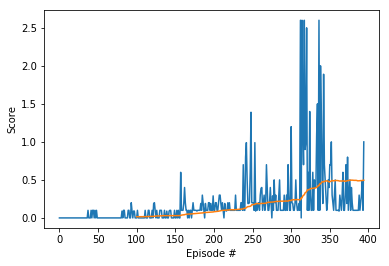

In [4]:
# Calculate average scores over 100 episodes
window = 100
avg_scores = []
for i in range(len(scores) - window):
    avg_scores.append(np.mean(scores[i:i + window]))
    
# Plot the scores and average
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(window, len(avg_scores) + window), avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [5]:
env.close()